# 0. Introdução

Este projeto é um complemento e atualização de um projeto anterior. O objetivo é realizar algumas mudanças do que foi aprendido sobre Ciência de dados e Machine Learning ao longo de alguns meses.

O [projeto anterior](https://medium.com/@p.tavares/churn-prediction-f3448db52e73) realizou uma análise bidimensional dos dados e a construção de um modelo Support Vector Machine (SVC), que possuiu as melhores métricas avaliadas naquele momento.

A taxa de churn, ou simplesmente churn, é o índice que representa a taxa de perda de clientes num banco de dados. É uma métrica crucial para a gestão, pois sua análise ao longo do tempo pode revelar problemas que precisam ser tratados.

O churn pode ser calculado em períodos, como mensal ou anualmente. Todas as empresas estão sujeitas a perda de clientes. Para isso é necessária uma ação para conquistar e manter clientes. É necessário que as empresas tenham um investimento em estudo de churn rate da sua base. Bem como, conhecer seus pontos fracos e fortes para estabelecer planos e estratégias.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>


Além disso, o churn pode ser utilizado para antecipar cancelamentos potenciais, permitindo ações direcionadas para reter esses clientes. Essa métrica demanda atenção especial, já que o Custo de Aquisição de Cliente (CAC) geralmente é maior do que o custo de mantê-los. Em resumo, altas taxas de churn são indesejáveis, pois indicam uma perda de clientes que é mais custosa do que mantê-los.

In [56]:
# IMPORTANDO PACOTES

# ignorando avisos
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# pacotes para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pacotes de processamento de dados
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, ColumnTransformer


# pacotes de balanceamento

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


# modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier



# avaliações e testes de modelos
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

Os dados utilizados neste projeto foram originalmente disponibilizados na plataforma de educação IBM Developer e estão relacionados a um problema típico enfrentado por uma empresa de telecomunicações. Embora informações explícitas possam não estar prontamente disponíveis, os nomes das colunas fornecem uma compreensão do problema. Um projeto anterior foi realizado utilizando este conjunto de dados.

In [2]:
# IMPORTANDO DADOS
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# 1. Informação dos dados e análise univariada


In [3]:
def data_info(df):
    print('Número de entradas (linhas): ', df.shape[0])
    print('\nNúmero de variáveis (colunas): ', df.shape[1])
    print("\nNome das variáveis:\n{}".format(df.columns.values))
    print("\nTipos de cada variável:\n{}".format(df.dtypes))
    print("\nValores únicos (por coluna):\n{}".format(df.nunique().sort_values(ascending=False)))
    print("\nPorcentagem de valores ausentes (por coluna):\n{}".format((df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False)))

A função acima utilizada para verificar:

- Número de entradas (linhas) e Número de variáveis (colunas): mostram quantas linhas (entradas) e colunas (variáveis) existem no conjunto de dados.
- Nome das variáveis: lista os nomes das colunas do conjunto de dados.
- Tipos de cada variável: exibe os tipos de dados presentes em cada coluna do conjunto de dados (por exemplo, int, float, object).
- Valores únicos (por coluna): mostra a contagem de valores únicos em cada coluna, ordenados de forma decrescente. Isso pode servir para entender a diversidade dos dados.
- Porcentagem de valores ausentes (por coluna): calcula a porcentagem de valores faltantes em cada coluna do conjunto de dados. Isso ajuda a identificar quais colunas têm mais dados ausentes, o que é crucial para limpeza e preparação dos dados.

Essas informações são essenciais para entender a estrutura do conjunto de dados, identificar possíveis problemas, como valores ausentes, e decidir quais etapas de pré-processamento de dados podem ser necessárias antes de realizar análises mais avançadas ou modelagem de dados. É uma maneira rápida de ter uma visão geral do estado inicial dos dados e das possíveis áreas que precisam de atenção.


In [4]:
data_info(df)

Número de entradas (linhas):  7043

Número de variáveis (colunas):  21

Nome das variáveis:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Tipos de cada variável:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn          


17 variáveis categóricas:

- customerID - código de identificação do cliente;
- gender  - gênero do cliente (male ou female);
- SeniorCitizen - se o cliente é aposentado ou não (1,0);
- Partner - se o cliente é casado ou não (Yes, No);
- Dependent - se o cliente possui dependentes ou não (Yes, No)
- PhoneService - se possui serviço telefônico (Yes, No);
- MultipleLines - se possui múltiplas linhas telefônicas (Yes, No, No phone service);
- InternetService - provedor de internet utilizado (DSL, Fiber optic, No);
- OnlineSecurity - se o cliente possui serviço de segurança online (Yes, No, No internet service)
- OnlineBackup - se o cliente possui serviço de backup online (Yes, No, No internet service)
- DeviceProtection - se o cliente possui serviço de proteção do sistema (Yes, No, No internet service)
- TechSupport - se o cliente possui ativado algum serviço de suporte (Yes, No, No internet service)
- StreamingTV - se o cliente possui serviço de streaming de tv (Yes, No, No internet service)
- StreamingMovies - se cliente possui serviço de streaming de filmes (Yes, No, No internet service)
- Contract - tipo de contrato do cliente (Month-to-month, one year, two years)
- PaperlessBilling - utilização de faturamento sem papel (Month-to-month, one year, two years)
- PaymentMethod - método de pagamento do cliente (Electronic check, Mailed check, Bank transfer (automatic), credit card (automatic))

3 variáveis numéricas:
- tenure - por quantos meses o indivíduo é cliente;
- MonthlyCharges - quantidade do pagamento mensal do cliente
- TotalCharges - quantidade total paga pelo cliente

1 variável alvo:
- Churn - se o cliente irá cancelar a assinatura (Yes, No)


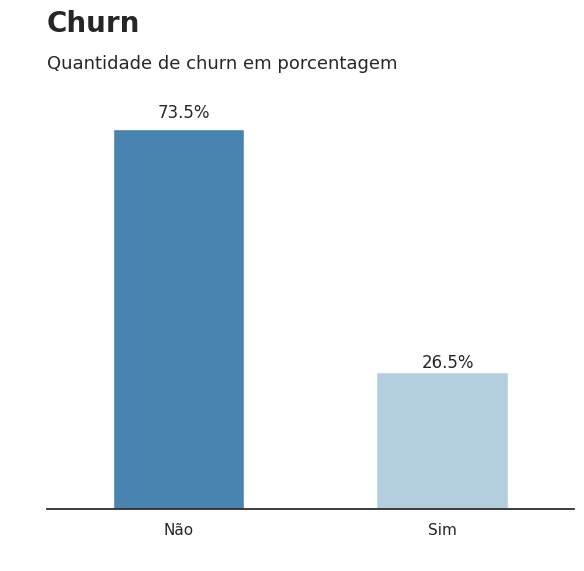

In [5]:
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize = (6,6))

ax = sns.countplot(x=df.Churn, data=df, palette="Blues_r", width=0.5)

ax.text(-0.5, 6500, 'Churn', fontsize = 20, fontweight='bold')
ax.text(-0.5, 6000, 'Quantidade de churn em porcentagem', fontsize = 13)
ax.set_yticklabels([])
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xticklabels(["Não", "Sim"])
sns.despine(left=True)

total = len(df.Churn)
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 2.9
  y = p.get_y() + p.get_height() * 1.03
  ax.annotate(percentage, (x,y), size = 12)

plt.tight_layout()
plt.show()

A partir daqui, observa-se que o problema abordado é uma classificação binária.O que será previsto são os clientes que cancelarão o serviço no mês previsto.

Além disso, nota-se que dentro do conjunto de dados, há mais pessoas que não cancelaram o serviço. Isso é identificado por um desequilíbrio entre as duas categorias, exigindo um procedimento de balanceamento a ser realizado posteriormente.

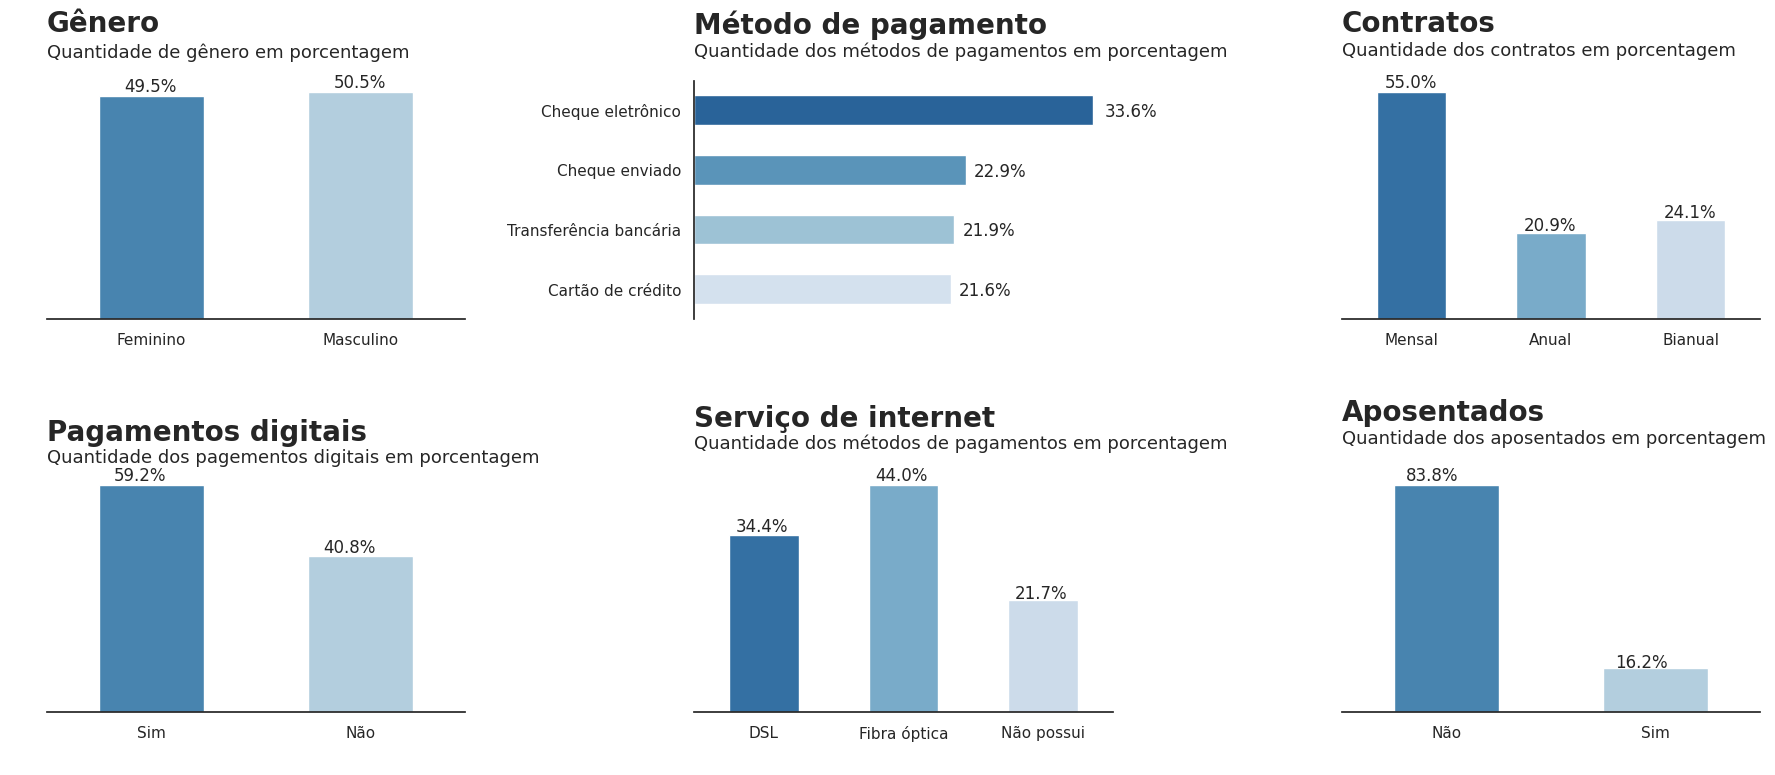

In [6]:
sns.set_theme(style="white")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 8))

# ax1
sns.countplot(x=df.gender, data=df, palette="Blues_r", width=0.5, ax= ax1)
ax1.text(-0.5, 4500, 'Gênero', fontsize = 20, fontweight='bold')
ax1.text(-0.5, 4100, 'Quantidade de gênero em porcentagem', fontsize = 13)
ax1.set_yticklabels([])
ax1.set_xticklabels(["Feminino", "Masculino"])
ax1.set_ylabel(" ")
ax1.set_xlabel(" ")
sns.despine(left=True, ax=ax1)

total = len(df.gender)
for p in ax1.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 4.2
  y = p.get_y() + p.get_height() * 1.02
  ax1.annotate(percentage, (x,y), size = 12)

#ax2
sns.countplot(y=df.PaymentMethod, data=df, palette="Blues_r", width=0.5, ax= ax2)
ax2.text(0, -1.3, 'Método de pagamento', fontsize = 20, fontweight='bold')
ax2.text(0, -0.9, 'Quantidade dos métodos de pagamentos em porcentagem', fontsize = 13)
ax2.set_xticklabels([])
ax2.set_yticklabels(["Cheque eletrônico", "Cheque enviado", "Transferência bancária", "Cartão de crédito"])
ax2.set_ylabel(" ")
ax2.set_xlabel(" ")
sns.despine(bottom=True, ax=ax2)

total = len(df.PaymentMethod)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_width() * 1.03
    y = p.get_y() + p.get_height() / 1.4
    ax2.annotate(percentage, (x, y), size=12)


# ax3
sns.countplot(x=df.Contract, data=df, palette="Blues_r", width=0.5, ax= ax3)
ax3.text(-0.5, 4900, 'Contratos', fontsize = 20, fontweight='bold')
ax3.text(-0.5, 4500, 'Quantidade dos contratos em porcentagem', fontsize = 13)
ax3.set_yticklabels([])
ax3.set_xticklabels(["Mensal", "Anual", "Bianual"])
ax3.set_ylabel(" ")
ax3.set_xlabel(" ")
sns.despine(left=True, ax=ax3)

total = len(df.Contract)
for p in ax3.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 9
  y = p.get_y() + p.get_height() * 1.02
  ax3.annotate(percentage, (x,y), size = 12)

# ax4
sns.countplot(x=df.PaperlessBilling, data=df, palette="Blues_r", width=0.5, ax= ax4)
ax4.text(-0.5, 5000, 'Pagamentos digitais', fontsize = 20, fontweight='bold')
ax4.text(-0.5, 4600, 'Quantidade dos pagementos digitais em porcentagem', fontsize = 13)
ax4.set_yticklabels([])
ax4.set_xticklabels(["Sim", "Não"])
ax4.set_ylabel(" ")
ax4.set_xlabel(" ")
sns.despine(left=True, ax=ax4)

total = len(df.PaperlessBilling)
for p in ax4.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 7
  y = p.get_y() + p.get_height() * 1.02
  ax4.annotate(percentage, (x,y), size = 12)


# ax5
sns.countplot(x=df.InternetService, data=df, palette="Blues_r", width=0.5, ax= ax5)
ax5.text(-0.5, 3900, 'Serviço de internet', fontsize = 20, fontweight='bold')
ax5.text(-0.5, 3600, 'Quantidade dos métodos de pagamentos em porcentagem', fontsize = 13)
ax5.set_yticklabels([])
ax5.set_xticklabels(["DSL", "Fibra óptica", "Não possui"])
ax5.set_ylabel(" ")
ax5.set_xlabel(" ")
sns.despine(left=True, ax=ax5)

total = len(df.InternetService)
for p in ax5.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 10
  y = p.get_y() + p.get_height() * 1.02
  ax5.annotate(percentage, (x,y), size = 12)


# ax6
sns.countplot(x=df.SeniorCitizen, data=df, palette="Blues_r", width=0.5, ax= ax6)
ax6.text(-0.5, 7600, 'Aposentados', fontsize = 20, fontweight='bold')
ax6.text(-0.5, 7000, 'Quantidade dos aposentados em porcentagem', fontsize = 13)
ax6.set_xticklabels(["Não", "Sim"])
ax6.set_yticklabels([])
ax6.set_ylabel(" ")
ax6.set_xlabel(" ")
sns.despine(left=True, ax=ax6)

total = len(df.SeniorCitizen)
for p in ax6.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 9
  y = p.get_y() + p.get_height() * 1.02
  ax6.annotate(percentage, (x,y), size = 12)


plt.tight_layout()
plt.show()

Analisando algumas características categóricas, pode-se concluir que:

- Há mais homens no conjunto de dados que utilizam os serviços da TELECOM.
- A maioria das pessoas opta por usar cheques eletrônicos em vez de cartões de crédito para métodos de pagamento automáticos.
- As pessoas tendem a preferir contratos mensais.
- A preferência é por faturas sem papel.
- A fibra óptica é o principal serviço de internet contratado com a TELECOM.
- A maioria das pessoas não são idosas.


É observado nas informações dos dados que a variável `TotalCharges` é um objeto. Porém, a informação contida nessa variável deveria ser numérica. Para analisar essa característica, ela será convertida e, se houver algum valor nulo, será preenchido com a mediana.

In [7]:
# Converte a coluna 'TotalCharges' para o tipo numérico. O método pd.to_numeric() tenta converter os valores da coluna para numéricos.
# O argumento errors='coerce' faz com que qualquer valor que não possa ser convertido para numérico seja transformado em NaN (valor ausente).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Aqui, é preenchido qualquer valor ausente (NaN) na coluna 'TotalCharges' com a mediana dos valores não ausentes dessa mesma coluna.
# O método fillna() preenche os valores ausentes com o valor especificado, que neste caso é a mediana da coluna 'TotalCharges'.
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

<ipython-input-8-f25123fb85f9>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = df.tenure, data = df, ax= ax1, palette="Blues_r")
<ipython-input-8-f25123fb85f9>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = df.MonthlyCharges, data = df, ax= ax2, palette="Blues_r")
<ipython-input-8-f25123fb85f9>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = df.TotalCharges, data = df, ax= ax3, palette="Blues_r")


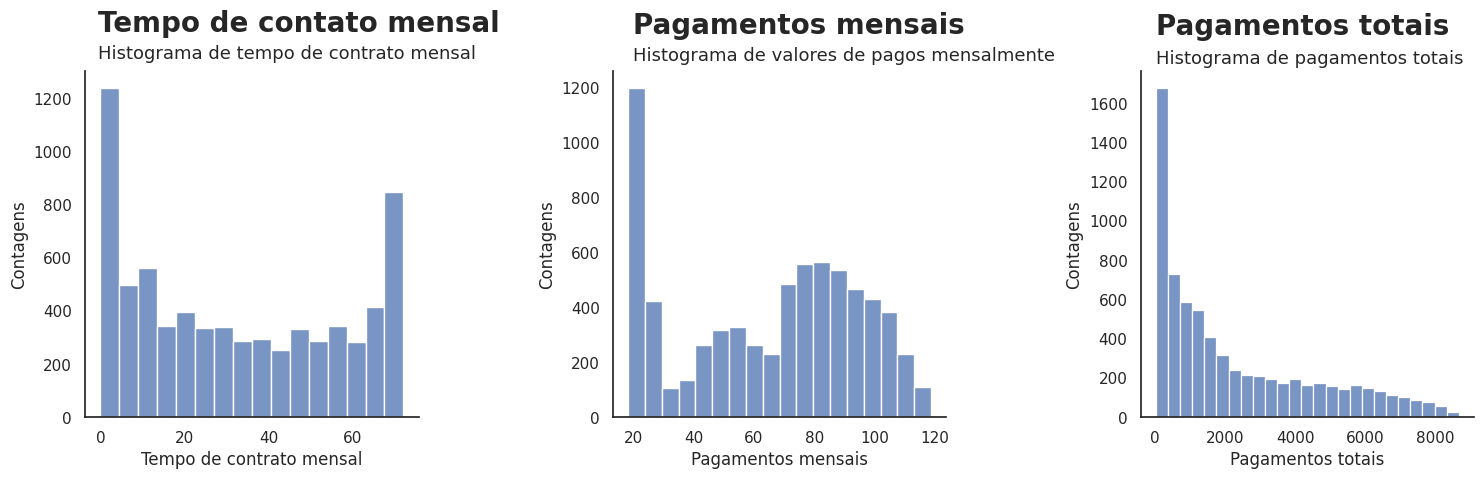

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(x = df.tenure, data = df, ax= ax1, palette="Blues_r")
ax1.set_ylabel("Contagens")
ax1.set_xlabel("Tempo de contrato mensal")
ax1.text(-0.5, 1450, 'Tempo de contato mensal', fontsize = 20, fontweight='bold')
ax1.text(-0.5, 1350, 'Histograma de tempo de contrato mensal', fontsize = 13)

sns.histplot(x = df.MonthlyCharges, data = df, ax= ax2, palette="Blues_r")
ax2.set_ylabel("Contagens")
ax2.set_xlabel("Pagamentos mensais")
ax2.text(20, 1400, 'Pagamentos mensais', fontsize = 20, fontweight='bold')
ax2.text(20, 1300, 'Histograma de valores de pagos mensalmente', fontsize = 13)

sns.histplot(x = df.TotalCharges, data = df, ax= ax3, palette="Blues_r")
ax3.set_ylabel("Contagens")
ax3.set_xlabel("Pagamentos totais")
ax3.text(20, 1950, 'Pagamentos totais', fontsize = 20, fontweight='bold')
ax3.text(20, 1800, 'Histograma de pagamentos totais', fontsize = 13)


sns.despine()
plt.tight_layout()
plt.show()

Observando as variáveis `Tenure` (tempo de contrato mensal) e `MonthlyCharge` (valor pago mensalmente) é visto que:

- A maior parte dos clientes estão entre 0 e 5 meses.
- Existe uma concentração de clientes que pagaram entre \$70,00 a \$100,00.
- Uma grande parte dos clientes realizaram pagamentos menos de \$2000,00.

# 2. Análise bivariada

A análise bivariada é fundamental na exploração desses dados, pois examina a relação variável Churn e as demais variáveis dentro do conjunto de dados. Outras razões são:


- Identificação de Relacionamentos: Ajuda a identificar se existe alguma associação ou relação entre as duas variáveis. Crucial para entender a dinâmica dos dados e pode ser fundamental para tomada de decisões.
- Validação de Hipóteses: Permite testar hipóteses ou suposições sobre a relação entre variáveis. Por exemplo, se acredita-se que dois fatores estão correlacionados, a análise bivariada pode confirmar ou refutar essa suposição.
- Previsão e Modelagem: Em muitos casos, modelos preditivos se baseiam na relação entre variáveis. A análise bivariada pode ajudar na seleção de variáveis importantes para esses modelos, identificando aquelas que têm forte associação com a variável-alvo.
- Visualização e Compreensão: Gráficos e representações visuais de análises bivariadas ajudam na compreensão dos padrões nos dados. Neste caso para as variáveis categóricas será apresentado gráficos de barras e para as numéricas histogramas.

Para esta análise é interessante trabalhar com uma divisão por subconjuntos, para uma melhor organização das conclusões. Supõe-se que a empresa esteja apenas interessada no perfil dos clientes, ou que seja apenas interessante os serviços que cada cliente possui, então realizar essa divisão torna a apresentação dos dados mais compreensível e objetiva.

## Variáveis categóricas demográficas

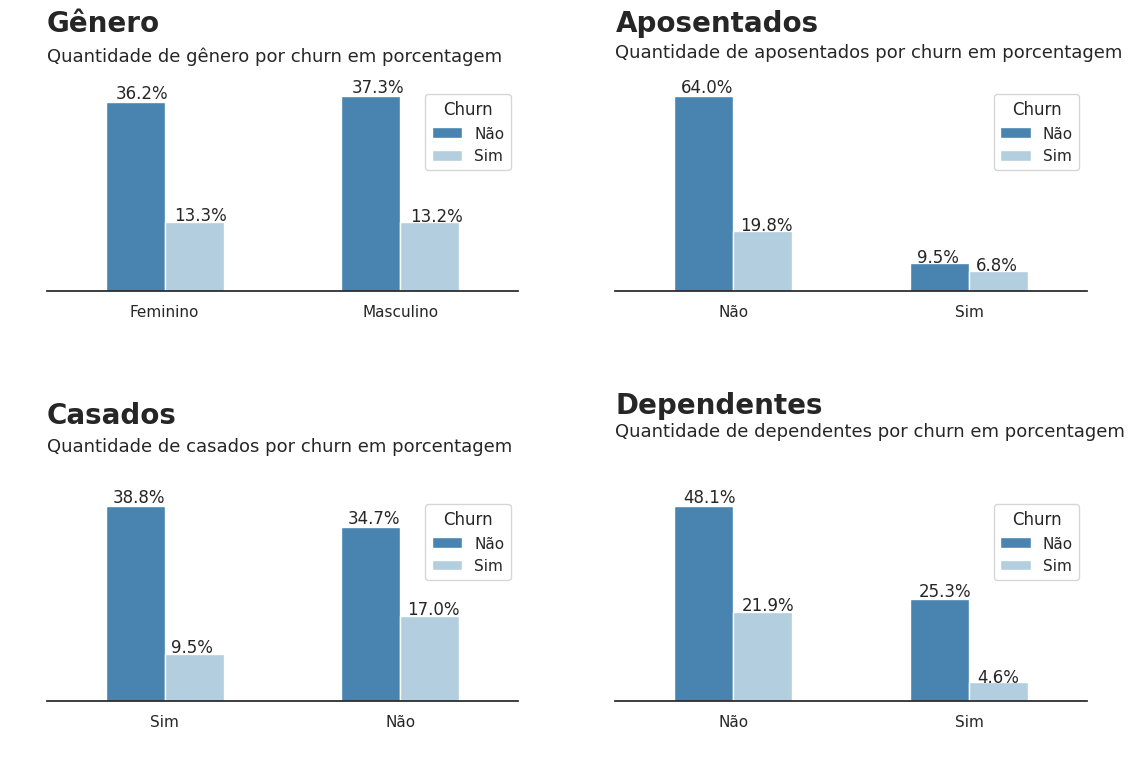

In [9]:
sns.set_theme(style="white")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# ax1
sns.countplot(x=df.gender, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax1)
ax1.text(-0.5, 3500, 'Gênero', fontsize = 20, fontweight='bold')
ax1.text(-0.5, 3100, 'Quantidade de gênero por churn em porcentagem', fontsize = 13)
ax1.set_yticklabels([])
ax1.set_xticklabels(["Feminino", "Masculino"])
ax1.set_ylabel(" ")
ax1.set_xlabel(" ")
ax1.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax1)

total = len(df.gender)
for p in ax1.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax1.annotate(percentage, (x,y), size = 12)

#ax2
sns.countplot(x=df.SeniorCitizen, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax2)
ax2.text(-0.5, 6000, 'Aposentados', fontsize = 20, fontweight='bold')
ax2.text(-0.5, 5400, 'Quantidade de aposentados por churn em porcentagem', fontsize = 13)
ax2.set_xticklabels(["Não", "Sim"])
ax2.set_yticklabels([])
ax2.set_ylabel(" ")
ax2.set_xlabel(" ")
ax2.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax2)

total = len(df.SeniorCitizen)
for p in ax2.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 9
  y = p.get_y() + p.get_height() * 1.02
  ax2.annotate(percentage, (x,y), size = 12)


# ax3
sns.countplot(x=df.Partner, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax3)
ax3.text(-0.5, 3900, 'Casados', fontsize = 20, fontweight='bold')
ax3.text(-0.5, 3500, 'Quantidade de casados por churn em porcentagem', fontsize = 13)
ax3.set_yticklabels([])
ax3.set_xticklabels(["Sim", "Não"])
ax3.set_ylabel(" ")
ax3.set_xlabel(" ")
ax3.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax3)

total = len(df.Partner)
for p in ax3.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 9
  y = p.get_y() + p.get_height() * 1.02
  ax3.annotate(percentage, (x,y), size = 12)

# ax4
sns.countplot(x=df.Dependents, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax4)
ax4.text(-0.5, 5000, 'Dependentes', fontsize = 20, fontweight='bold')
ax4.text(-0.5, 4600, 'Quantidade de dependentes por churn em porcentagem', fontsize = 13)
ax4.set_yticklabels([])
ax4.set_xticklabels(["Não", "Sim"])
ax4.set_ylabel(" ")
ax4.set_xlabel(" ")
ax4.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax4)

total = len(df.Dependents)
for p in ax4.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 7
  y = p.get_y() + p.get_height() * 1.02
  ax4.annotate(percentage, (x,y), size = 12)

plt.tight_layout()
plt.show()

Em uma análise das variáveis demográficas vemos:
- A diferença entre homens e mulheres que cancelam o serviço é menor que 1%.
- Pessoas não aposentadas costumam cancelar mais o serviço em comparação aos aposentados.
- Clientes casados cancelam menos o serviço que os não casados.
- Aqueles que não possuem dependentes cancelam mais o serviço em relação aos que possuem.

## Variáveis categóricas que representam os seviços assinados pelo cliente

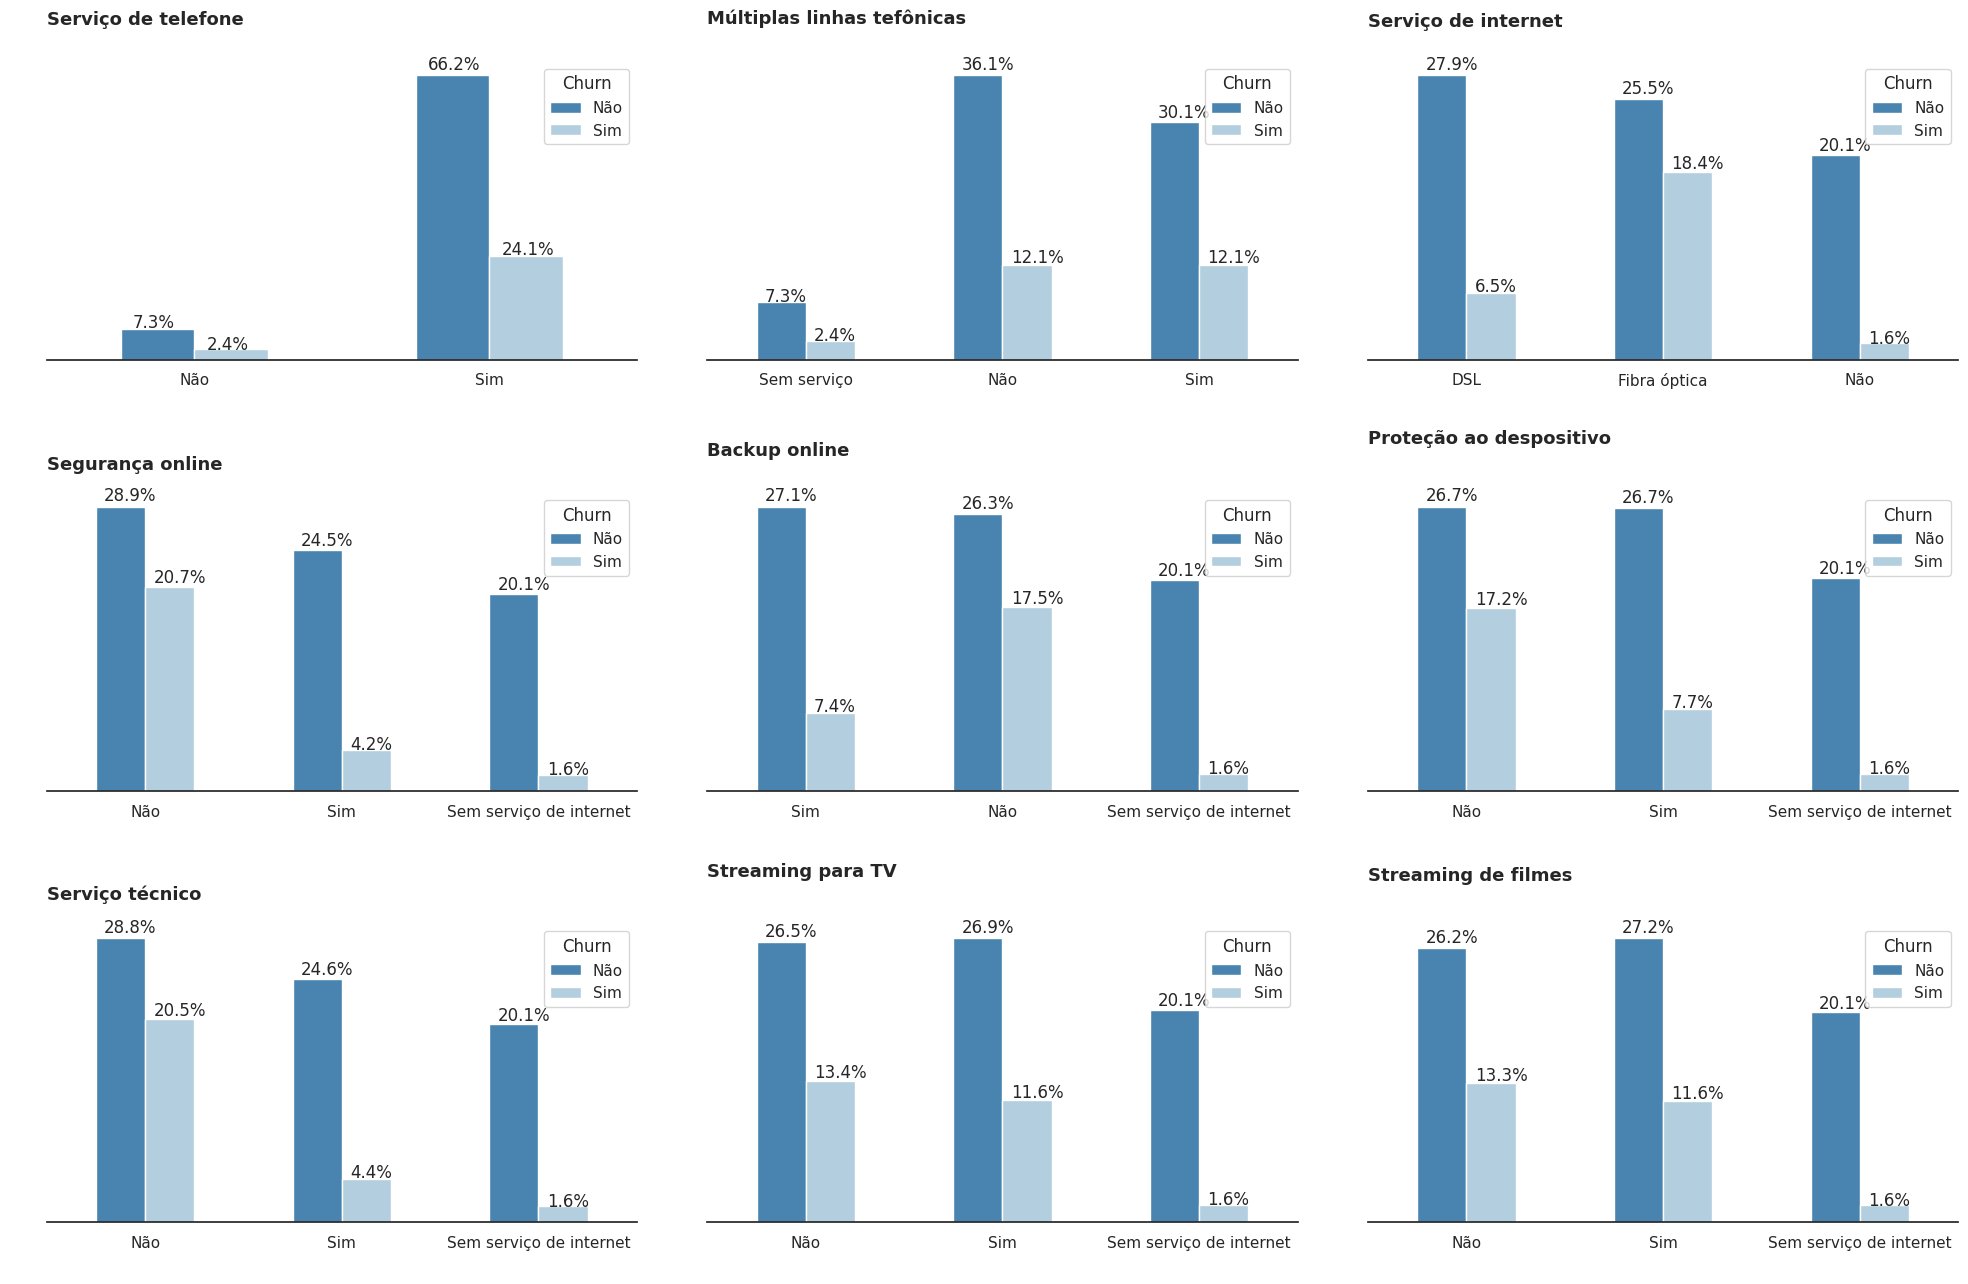

In [10]:
sns.set_theme(style="white")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 13))

# ax1
sns.countplot(x=df.PhoneService, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax1)
ax1.text(-0.5, 5500, 'Serviço de telefone', fontsize = 13, fontweight='bold')
ax1.set_yticklabels([])
ax1.set_xticklabels(["Não", "Sim"])
ax1.set_ylabel(" ")
ax1.set_xlabel(" ")
ax1.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax1)

total = len(df.PhoneService)
for p in ax1.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax1.annotate(percentage, (x,y), size = 12)

# ax2
sns.countplot(x=df.MultipleLines, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax2)
ax2.text(-0.5, 3000, 'Múltiplas linhas tefônicas', fontsize = 13, fontweight='bold')
ax2.set_yticklabels([])
ax2.set_xticklabels(["Sem serviço", "Não", "Sim"])
ax2.set_ylabel(" ")
ax2.set_xlabel(" ")
ax2.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax2)

total = len(df.MultipleLines)
for p in ax2.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax2.annotate(percentage, (x,y), size = 12)


# ax3
sns.countplot(x=df.InternetService, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax3)
ax3.text(-0.5, 2300, 'Serviço de internet', fontsize = 13, fontweight='bold')
ax3.set_yticklabels([])
ax3.set_xticklabels(["DSL", "Fibra óptica", "Não"])
ax3.set_ylabel(" ")
ax3.set_xlabel(" ")
ax3.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax3)

total = len(df.InternetService)
for p in ax3.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax3.annotate(percentage, (x,y), size = 12)


# ax4
sns.countplot(x=df.OnlineSecurity, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax4)
ax4.text(-0.5, 2300, 'Segurança online', fontsize = 13, fontweight='bold')
ax4.set_yticklabels([])
ax4.set_xticklabels(["Não", "Sim", "Sem serviço de internet"])
ax4.set_ylabel(" ")
ax4.set_xlabel(" ")
ax4.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax4)

total = len(df.OnlineSecurity)
for p in ax4.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax4.annotate(percentage, (x,y), size = 12)

# ax5
sns.countplot(x=df.OnlineBackup, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax5)
ax5.text(-0.5, 2250, 'Backup online', fontsize = 13, fontweight='bold')
ax5.set_yticklabels([])
ax5.set_xticklabels(["Sim", "Não", "Sem serviço de internet"])
ax5.set_ylabel(" ")
ax5.set_xlabel(" ")
ax5.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax5)

total = len(df.OnlineBackup)
for p in ax5.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax5.annotate(percentage, (x,y), size = 12)

# ax6
sns.countplot(x=df.DeviceProtection, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax6)
ax6.text(-0.5, 2300, 'Proteção ao despositivo ', fontsize = 13, fontweight='bold')
ax6.set_yticklabels([])
ax6.set_xticklabels(["Não", "Sim", "Sem serviço de internet"])
ax6.set_ylabel(" ")
ax6.set_xlabel(" ")
ax6.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax6)

total = len(df.DeviceProtection)
for p in ax6.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax6.annotate(percentage, (x,y), size = 12)


# ax7
sns.countplot(x=df.TechSupport, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax7)
ax7.text(-0.5, 2300, 'Serviço técnico', fontsize = 13, fontweight='bold')
ax7.set_yticklabels([])
ax7.set_xticklabels(["Não", "Sim", "Sem serviço de internet"])
ax7.set_ylabel(" ")
ax7.set_xlabel(" ")
ax7.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax7)

total = len(df.TechSupport)
for p in ax7.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax7.annotate(percentage, (x,y), size = 12)

# ax8
sns.countplot(x=df.StreamingTV, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax8)
ax8.text(-0.5, 2300, 'Streaming para TV', fontsize = 13, fontweight='bold')
ax8.set_yticklabels([])
ax8.set_xticklabels(["Não", "Sim", "Sem serviço de internet"])
ax8.set_ylabel(" ")
ax8.set_xlabel(" ")
ax8.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax8)

total = len(df.StreamingTV)
for p in ax8.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax8.annotate(percentage, (x,y), size = 12)


# ax9
sns.countplot(x=df.StreamingMovies, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax9)
ax9.text(-0.5, 2300, 'Streaming de filmes', fontsize = 13, fontweight='bold')
ax9.set_yticklabels([])
ax9.set_xticklabels(["Não", "Sim", "Sem serviço de internet"])
ax9.set_ylabel(" ")
ax9.set_xlabel(" ")
ax9.legend(['Não', 'Sim'], title = 'Churn')
sns.despine(left=True, ax=ax9)

total = len(df.StreamingMovies)
for p in ax9.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 6
  y = p.get_y() + p.get_height() * 1.02
  ax9.annotate(percentage, (x,y), size = 12)

plt.tight_layout()
plt.show()

Sobre a análise dos serviços assinados pelos clientes:
 -  90.3% dos clientes possuem serviço de telefonia e possuem a maior taxa de cancelamento.
 - Os clientes com fibra óptica são os que mais cancelam em relação aos DSL.
 - Os clientes que assinam os serviços de OnlineSecurity, OnlineBackup, DeviceProtection e TechSupport são os que menos cancelam as assinaturas.
 - Existe uma proximidade entre os dados de streaming de TV e filmes, podendo até não ser um critério para o cancelamento.


## Variáveis sobre os pagamentos dos clientes

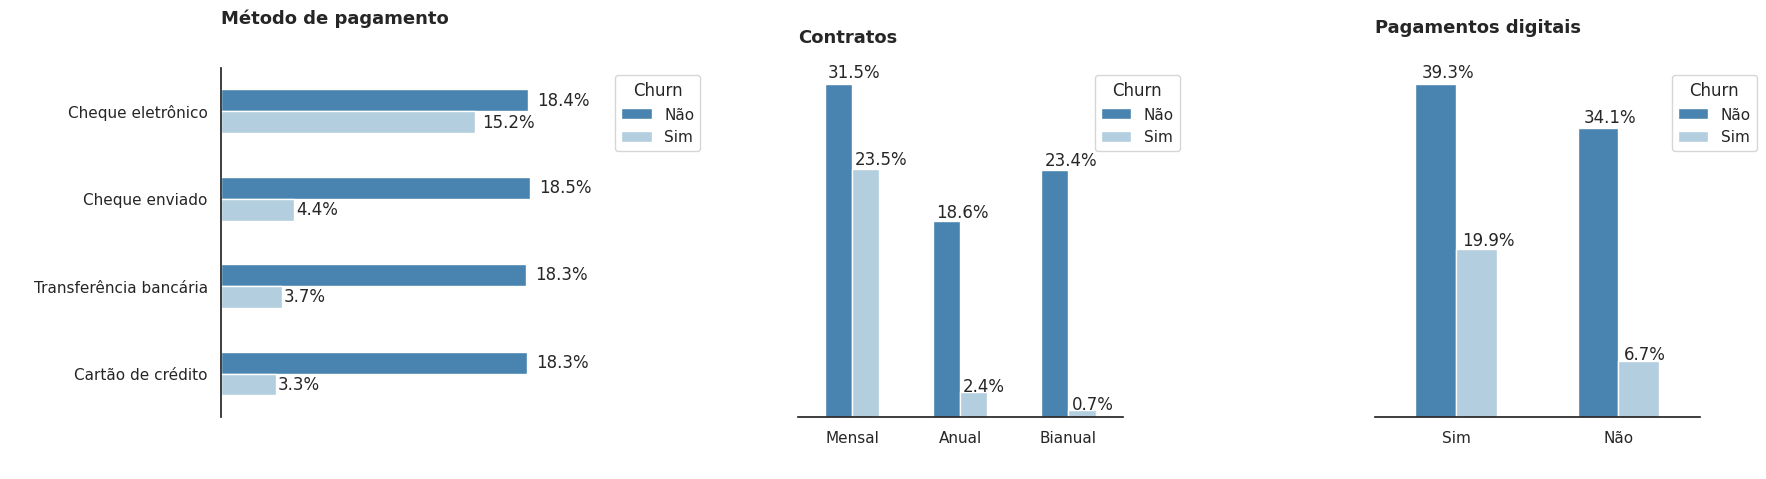

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))


#ax1
sns.countplot(y=df.PaymentMethod, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax1)
ax1.text(0, -1, 'Método de pagamento', fontsize = 13, fontweight='bold')
ax1.set_xticklabels([])
ax1.set_yticklabels(["Cheque eletrônico", "Cheque enviado", "Transferência bancária", "Cartão de crédito"])
ax1.set_ylabel(" ")
ax1.set_xlabel(" ")
ax1.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.5, 1))
sns.despine(bottom=True, ax=ax1)

total = len(df.PaymentMethod)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_width() * 1.03
    y = p.get_y() + p.get_height() / 1.4
    ax1.annotate(percentage, (x, y), size=12)


# ax2
sns.countplot(x=df.Contract, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax2)
ax2.text(-0.5, 2500, 'Contratos', fontsize = 13, fontweight='bold')
ax2.set_yticklabels([])
ax2.set_xticklabels(["Mensal", "Anual", "Bianual"])
ax2.set_ylabel(" ")
ax2.set_xlabel(" ")
ax2.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.2, 1))
sns.despine(left=True, ax=ax2)

total = len(df.Contract)
for p in ax2.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 9
  y = p.get_y() + p.get_height() * 1.02
  ax2.annotate(percentage, (x,y), size = 12)

# ax3
sns.countplot(x=df.PaperlessBilling, data=df, hue = df.Churn, palette="Blues_r", width=0.5, ax= ax3)
ax3.text(-0.5, 3200, 'Pagamentos digitais', fontsize = 13, fontweight='bold')
ax3.set_yticklabels([])
ax3.set_xticklabels(["Sim", "Não"])
ax3.set_ylabel(" ")
ax3.set_xlabel(" ")
ax3.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.2, 1))
sns.despine(left=True, ax=ax3)

total = len(df.PaperlessBilling)
for p in ax3.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width() / 7
  y = p.get_y() + p.get_height() * 1.02
  ax3.annotate(percentage, (x,y), size = 12)



plt.tight_layout()
plt.show()

A partir da análise dos dados de pagamento dos clientes é visto que:
- Os clientes com assinaturas mais curtas são os que mais cancelam.
- Aqueles clientes que não possuem faturamento por papel possuem o maior número de cancelamentos.
- E os clientes com o método de pagamento por cheque eletrônico são os que mais tendem a cancelar e esse é o modo mais comum de pagamento.


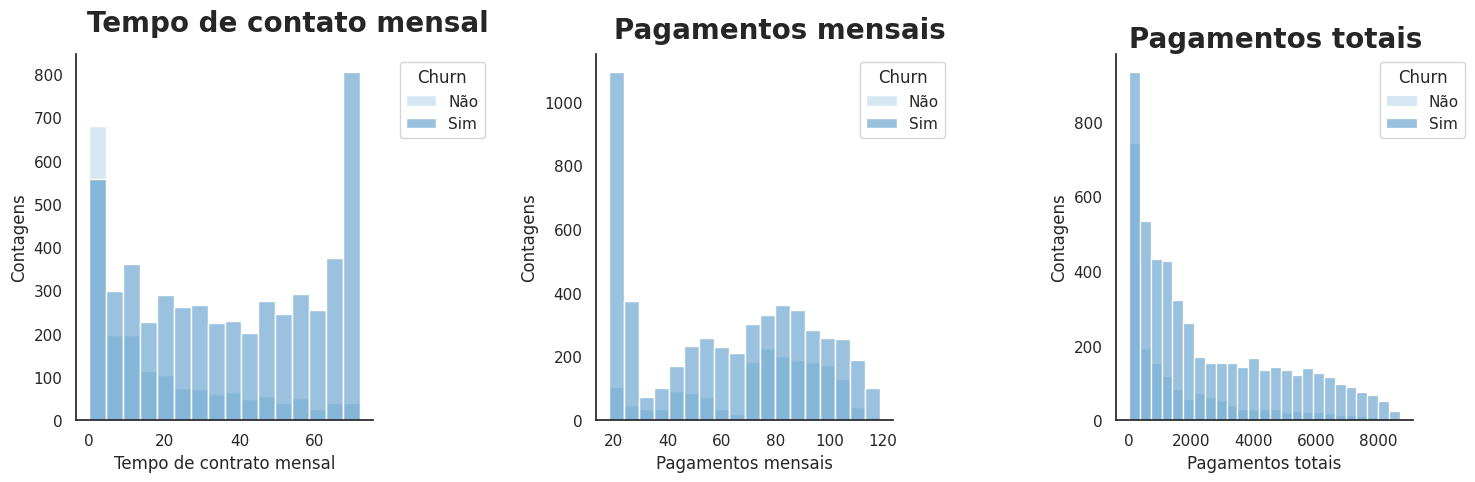

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(x = df.tenure, data = df, ax= ax1, hue = df.Churn, palette="Blues_r")
ax1.set_ylabel("Contagens")
ax1.set_xlabel("Tempo de contrato mensal")
ax1.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.4, 1))
ax1.text(-0.5, 900, 'Tempo de contato mensal', fontsize = 20, fontweight='bold')

sns.histplot(x = df.MonthlyCharges, data = df, ax= ax2, hue = df.Churn, palette="Blues_r")
ax2.set_ylabel("Contagens")
ax2.set_xlabel("Pagamentos mensais")
ax2.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.2, 1))
ax2.text(20, 1200, 'Pagamentos mensais', fontsize = 20, fontweight='bold')

sns.histplot(x = df.TotalCharges, data = df, ax= ax3, hue = df.Churn, palette="Blues_r")
ax3.set_ylabel("Contagens")
ax3.set_xlabel("Pagamentos totais")
ax3.legend(['Não', 'Sim'], title = 'Churn', loc ='upper right', bbox_to_anchor=(1.2, 1))
ax3.text(20, 1000, 'Pagamentos totais', fontsize = 20, fontweight='bold')


sns.despine()
plt.tight_layout()
plt.show()

Ao analisar as informações sobre os clientes, é possível observar que:

- A empresa registrou um número significativo de clientes nos primeiros meses (0-9 meses), porém, nesse mesmo período, houve um aumento notável nos cancelamentos.
- Os clientes que apresentam pagamentos mensais mais elevados são os mesmos que tendem a cancelar o serviço.

## Análise de correlação

Será feita uma análise de correlação de Pearson para identificar colunas correlacionadas entre si. Isso permitirá usar a Análise de Componentes Principais (PCA). O coeficiente de correlação de Pearson avalia a relação linear entre variáveis, variando de -1 a +1. O PCA é uma técnica para reduzir a complexidade dos dados, identificando padrões e simplificando as variáveis. Usando a correlação de Pearson, podemos empregar o PCA para lidar com menos variáveis altamente correlacionadas, simplificando a análise sem perder informações cruciais.

In [13]:
df_forcorr = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

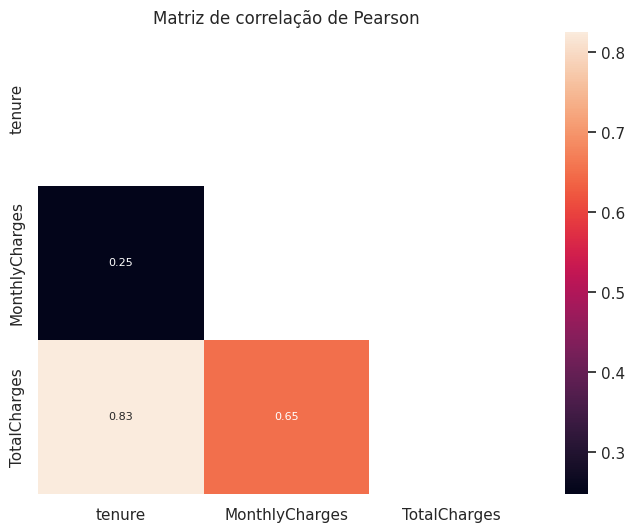

In [14]:
corr = df_forcorr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c", annot_kws={"size": 8})
plt.title("Matriz de correlação de Pearson")
plt.show()

- Correlação de 0.25 entre as variáveis MonthlyCharges e Tenure: sugere uma relação positiva, porém relativamente fraca, entre esses dois atributos. À medida que a quantidade de meses que um cliente permanece com o serviço (Tenure) aumenta um pouco, os encargos mensais (MonthlyCharges) também têm um aumento, mas não de forma considerável. Geralmente, correlações com valores menores que 0.3 são consideradas fracas ou moderadas, o que sugere que as mudanças em uma variável não estão fortemente relacionadas às mudanças na outra variável.

- Correlação de 0.83 entre TotalCharges e Tenure: sugere uma forte correlação positiva entre elas. Neste caso, isso indica que conforme a variável "Tenure" (tempo de permanência) aumenta, a variável "TotalCharges" (total de cobranças) também tende a aumentar consistentemente. Essa correlação alta sugere que há uma relação linear forte e positiva entre essas variáveis. Em termos práticos, isso poderia ser interpretado como clientes que permanecem por mais tempo (Tenure maior) tendem a gerar um total de cobranças (TotalCharges) mais elevado ao longo desse período. É importante notar que a correlação não implica necessariamente causalidade. Ou seja, apenas porque essas variáveis estão fortemente correlacionadas, não significa que uma causa diretamente a outra. Pode haver outros fatores ou variáveis que influenciam essa relação.

- Correlação de 0.65 entre TotalCharges e MonthlyCharge: sugere uma correlação positiva moderada entre essas variáveis.TotalCharges representa o total cobrado ao longo do tempo e MonthlyCharge é a cobrança mensal, uma correlação de 0.65 sugere que clientes com cobranças mensais mais altas tendem a acumular maiores montantes totais ao longo do tempo. Isso não implica causalidade, mas indica uma associação onde os clientes que pagam mais mensalmente, em média, tendem a acumular maiores valores totais ao longo do tempo. Esta informação pode ser valiosa para estratégias de precificação, retenção de clientes ou para entender os padrões de comportamento dos consumidores em um determinado serviço ou produto.

# 3. Feature engineering

## Corrigindo valors outliers

In [15]:
columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']

skewness_before = df[columns_numeric].skew()

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


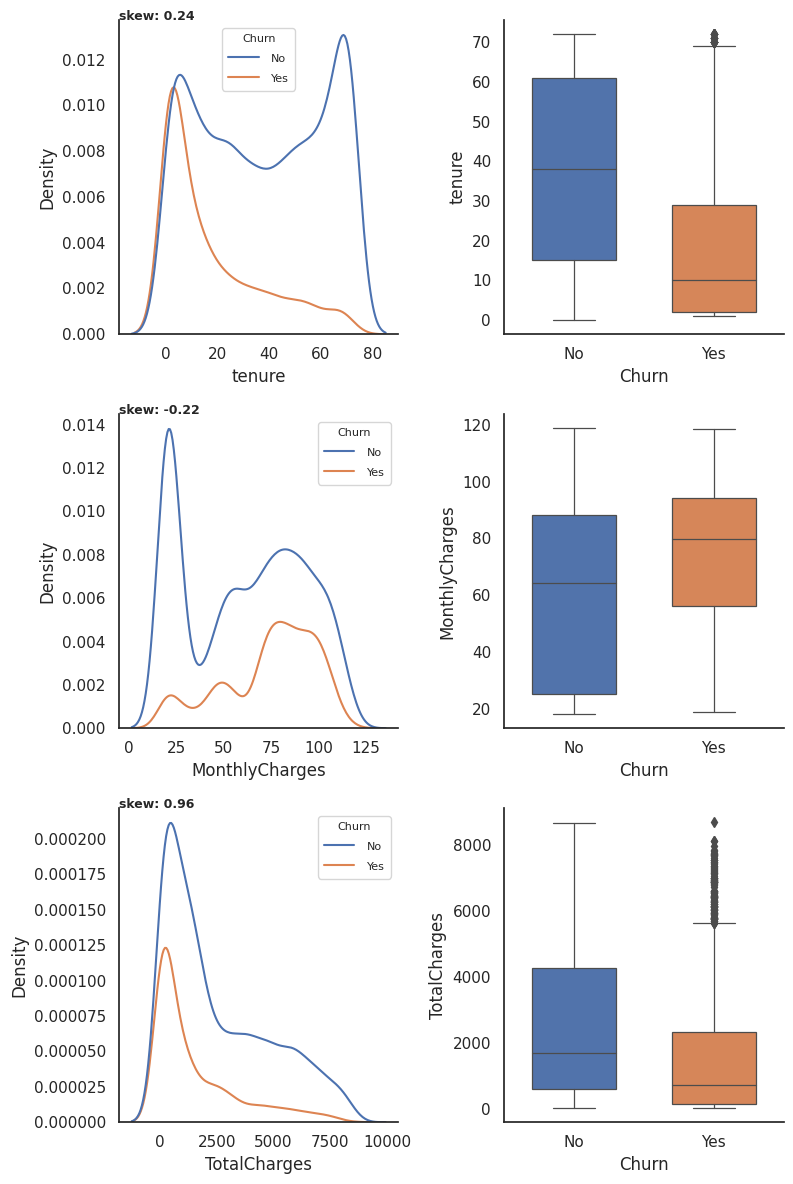

In [16]:
fig, axes = plt.subplots(3,2, figsize=(8,12))

axes = axes.flatten()
i = 0

from tqdm import tqdm

for column in tqdm(columns_numeric):
  ax = axes[i]
  sns.kdeplot(data =df, x=column, hue='Churn', ax=ax, fill=False, legend = True)
  skewness = skewness_before[column]
  ax.text(
      ax.get_xlim()[0],
      ax.get_ylim()[-1],
      f"skew: {skewness:.2f}",
      size = 9,
      weight = "bold"
  )
  legend = ax.get_legend()
  plt.setp(legend.get_title(), fontsize=8)
  for text in legend.get_texts():
        text.set_fontsize(8)
  ax = axes[i + 1]
  sns.boxplot(data=df, x="Churn", y=column, ax=ax,
              width=0.6,
              saturation=0.9,
              linewidth=0.9,
    )
  i += 2

sns.despine()
plt.tight_layout()
plt.show()

Os boxplots oferecem uma visão rápida sobre a distribuição dos dados, destacando valores extremos, chamados de outliers. Eles revelam que tanto na coluna de `TotalCharges` quanto na de `tenure` existem pontos fora do padrão, ou seja, valores que se destacam em relação à maioria dos dados.

Além disso, a medida de assimetria, representada pelo coeficiente de skewness, ajuda a entender a distribuição dos dados. Valores entre `-0,5` e `+0,5` indicam uma distribuição razoavelmente simétrica. No entanto, o histograma dos `TotalCharges` mostra um coeficiente de skewness de 0,96, o que indica uma assimetria significativa, sugerindo que os dados estão mais concentrados em um lado da distribuição do que no outro.


Para corrigir discrepâncias nos dados, será realizada a substituição dos outliers pela mediana, identificados usando o z-score. Essa medida estatística avalia a distância dos pontos em relação à média, destacando valores significativamente distantes, geralmente considerados além de 2.5 ou 3 desvios padrão.

In [17]:
df_new = df.copy()

In [18]:
from scipy import stats

# Vamos supor que seus dados estejam em uma coluna 'TotalCharges' do DataFrame df
z_scores = stats.zscore(df_new['TotalCharges'])

# Defina um limite para identificar outliers (geralmente, 2.5 ou 3)
limite_z_score = 2.5

# Encontre os índices dos outliers
outliers_indices = np.where(np.abs(z_scores) > limite_z_score)[0]

# Imprima os valores dos outliers
outliers_values = df_new.loc[outliers_indices, 'TotalCharges']

print("Valores de outliers:", outliers_values)

Valores de outliers: 193     8129.30
198     8041.65
369     8126.65
437     8468.20
464     8404.90
         ...   
6537    7968.85
6566    8152.30
6728    8349.70
6768    8670.10
6859    7985.90
Name: TotalCharges, Length: 90, dtype: float64


In [19]:
mediana_sem_outliers = np.median(df_new.loc[~df_new.index.isin(outliers_indices), 'TotalCharges'])

# Substitua os valores dos outliers pela mediana sem outliers
df_new.loc[outliers_indices, 'TotalCharges'] = mediana_sem_outliers

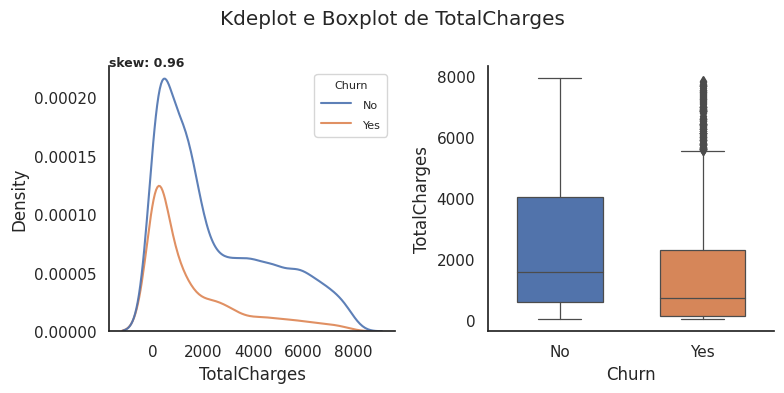

In [20]:
skewness = df_new['TotalCharges'].skew()


fig, axes = plt.subplots(1,2, figsize=(8,4))

axes = axes.flatten()


ax = axes[0]
sns.kdeplot(
    data=df_new, x="TotalCharges", hue="Churn", ax=ax, fill=False, alpha=0.9
)
ax.text(
    ax.get_xlim()[0], ax.get_ylim()[-1], f"skew: {skewness:.2f}", size=9, weight="bold"
)
legend = ax.get_legend()
plt.setp(legend.get_title(), fontsize=8)
for text in legend.get_texts():
    text.set_fontsize(8)

ax = axes[1]
sns.boxplot(
    data=df_new,
    x="Churn",
    y="TotalCharges",
    ax=ax,
    width=0.6,
    saturation=0.9,
    linewidth=0.9,
)
plt.suptitle("Kdeplot e Boxplot de TotalCharges")

sns.despine()
plt.tight_layout()
plt.show()

Apesar da substituição dos outliers, o valor de skew permanece em 0.96, indicando uma assimetria considerável nos dados. Diante disso, uma transformação adicional se faz necessária. Optou-se por aplicar a operação de raiz quadrada na variável TotalCharges como medida corretiva. Essa escolha busca mitigar a assimetria existente, possibilitando uma distribuição mais equilibrada e alinhada com as premissas de normalidade necessárias para análises estatísticas mais precisas.

In [21]:
df_new['sqrt_TotalCharges'] = df_new['TotalCharges'].apply(lambda x: x**0.5)

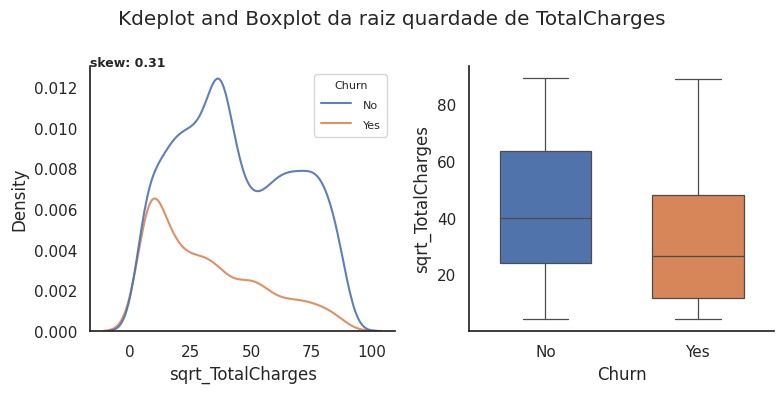

In [22]:
skewness = df_new['sqrt_TotalCharges'].skew()


fig, axes = plt.subplots(1,2, figsize=(8,4))

axes = axes.flatten()


ax = axes[0]
sns.kdeplot(
    data=df_new, x="sqrt_TotalCharges", hue="Churn", ax=ax, fill=False, alpha=0.9
)
ax.text(
    ax.get_xlim()[0], ax.get_ylim()[-1], f"skew: {skewness:.2f}", size=9, weight="bold"
)
legend = ax.get_legend()
plt.setp(legend.get_title(), fontsize=8)
for text in legend.get_texts():
    text.set_fontsize(8)

ax = axes[1]
sns.boxplot(
    data=df_new,
    x="Churn",
    y="sqrt_TotalCharges",
    ax=ax,
    width=0.6,
    saturation=0.9,
    linewidth=0.9,
)
plt.suptitle("Kdeplot and Boxplot da raiz quardade de TotalCharges")

sns.despine()
plt.tight_layout()
plt.show()

Agora é visto um valor de skew de 0.31. Indicando uma melhora na simetria da distribuição dos dados e também uma diminuição nos valores outliers da variável.

In [23]:
df_new.drop(['TotalCharges'], axis=1, inplace=True)

## Codificação de colunas categóricas e padronização das variáveis numéricas


A "codificação de colunas categóricas" é o processo de transformar variáveis categóricas, que representam diferentes categorias ou grupos, em dados numéricos compreensíveis para algoritmos de machine learning. Isso é necessário porque muitos algoritmos de aprendizado de máquina operam apenas com dados numéricos. Existem várias técnicas de codificação, como a codificação one-hot, que cria colunas binárias para cada categoria, ou a codificação de rótulos, que atribui um valor numérico único a cada categoria. Neste caso será usado o método One-Hot.

Já a "normalização das variáveis numéricas" é o procedimento de ajustar a escala das variáveis numéricas para que elas estejam em uma faixa comum. Isso é feito para evitar que algumas variáveis tenham um peso desproporcional nos modelos de machine learning devido às diferentes escalas. A normalização frequentemente envolve técnicas como a escala min-max (ajustando os valores para um intervalo específico, por exemplo, entre 0 e 1) ou a padronização (ajustando os valores para terem média zero e desvio padrão um). Aqui será usado a padronização nas variáveis numéricas.

In [24]:
df_new.drop(['customerID'], axis=1, inplace=True)

In [25]:
X = df_new.drop('Churn', axis = 1)
y = df_new['Churn']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=42)

In [27]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,sqrt_TotalCharges
6661,Female,0,Yes,Yes,72,No,No phone service,DSL,No,Yes,No,Yes,Yes,Yes,Two year,No,Credit card (automatic),53.65,61.514226
4811,Female,0,No,No,4,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,46.00,13.914022
2193,Male,0,No,Yes,56,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,21.20,35.194460
1904,Male,0,No,No,56,Yes,Yes,Fiber optic,No,Yes,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,94.45,71.586312
6667,Female,0,No,No,9,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,79.55,26.896096


Após a separação dos dados em teste e treinamento realiza-se agora agora a codificação e normalização dos dados.

In [28]:
unique_counts = df_new.select_dtypes("O").nunique()
binary_columns = unique_counts[unique_counts == 2].index.drop("Churn").tolist()
categorical_columns = unique_counts[unique_counts > 2].index.tolist()

In [29]:
transformer = ColumnTransformer(
    [
        ("scaler", StandardScaler(), ["MonthlyCharges", "sqrt_TotalCharges", "tenure"]),
        ("binary_encoder", OrdinalEncoder(), binary_columns),
        ("ohe", OneHotEncoder(drop="first"), categorical_columns),
    ],
    remainder="passthrough",
)

transformer.fit(X_train)
columns = transformer.get_feature_names_out()
columns = list(map(lambda x: str(x).split("__")[-1], columns))

X_train = pd.DataFrame(transformer.transform(X_train), columns=columns)
X_test = pd.DataFrame(transformer.transform(X_test), columns=columns)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [30]:
X_train.head()

,MonthlyCharges,sqrt_TotalCharges,tenure,gender,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen
0,-0.371461,0.885309,1.609608,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,-0.625032,-1.101253,-1.151780,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.447065,-0.213129,0.959870,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.980917,1.305661,0.959870,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.487034,-0.559455,-0.948737,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Balanceamento dos dados

Será utilizado o método SMOTE para balaceamento dos dados.

In [31]:
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)

# 4. Modelos de Machine Learning

In [32]:
def model_evaluation(X, y, model, verbose=True):
    """
    Função para avaliar um modelo de classificação usando validação cruzada e retornar diversas métricas de avaliação.

    Parâmetros:
    X (array-like): Matriz de características dos dados de treinamento.
    y (array-like): Vetor de rótulos dos dados de treinamento.
    model (estimador): Modelo de classificação a ser avaliado.
    verbose (bool, opcional): Se True, exibe as métricas de avaliação na saída padrão. Padrão é True.

    Retorna:
    Um dicionário com as métricas de avaliação do modelo.
    """
    # Transformando os dados de entrada em arrays numpy
    X = np.array(X)
    y = np.array(y)

    # Criando o pipeline de transformação e classificação
    pipeline = make_pipeline(StandardScaler(), model)

    # Realizando a validação cruzada do modelo e calculando as métricas de avaliação
    acc_scores = cross_val_score(pipeline, X, y, scoring='accuracy')
    recall_scores = cross_val_score(pipeline, X, y, scoring='recall')
    precision_scores = cross_val_score(pipeline, X, y, scoring='precision')
    f1_scores = cross_val_score(pipeline, X, y, scoring='f1')

    # Armazenando as métricas em um dicionário
    metrics = {
        'Accuracy': acc_scores.mean(),
        'Accuracy Std': acc_scores.std(),
        'Recall': recall_scores.mean(),
        'Recall Std': recall_scores.std(),
        'Precision': precision_scores.mean(),
        'Precision Std': precision_scores.std(),
        'F1 Score': f1_scores.mean(),
        'F1 Score Std': f1_scores.std()
    }

    # Exibindo as métricas se verbose=True
    if verbose:
        print(f'{model.__class__.__name__} metrics: {metrics}')

    # Retornando o dicionário de métricas
    return metrics

In [33]:
# Inicializando os modelos
logistic_regression = LogisticRegression()
xgb_classifier = XGBClassifier()
lgbm_classifier = LGBMClassifier()
svc_classifier = SVC()
random_forest = RandomForestClassifier()
decision_tree = DecisionTreeClassifier()
gradient_boosting = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()
naive_bayes = GaussianNB()
neural_network = MLPClassifier()

# Lista de modelos
models = [
    logistic_regression,
    xgb_classifier,
    lgbm_classifier,
    svc_classifier,
    random_forest,
    decision_tree,
    gradient_boosting,
    knn_classifier,
    naive_bayes,
    neural_network
]

metrics_dict = {}

In [34]:
for model in models:
    metrics = model_evaluation(X_train, y_train, model)
    model_name = model.__class__.__name__
    metrics_dict[model_name] = metrics

df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')

LogisticRegression metrics: {'Accuracy': 0.7742268041237114, 'Accuracy Std': 0.015563468225409037, 'Recall': 0.8002577319587628, 'Recall Std': 0.021823673329913973, 'Precision': 0.7612234105607657, 'Precision Std': 0.020123786385115354, 'F1 Score': 0.77995413302482, 'F1 Score Std': 0.01437219104436271}
XGBClassifier metrics: {'Accuracy': 0.8363402061855669, 'Accuracy Std': 0.08493529230693525, 'Recall': 0.8213917525773196, 'Recall Std': 0.20555573907409694, 'Precision': 0.8463879066230096, 'Precision Std': 0.00848795826153589, 'F1 Score': 0.819831838960986, 'F1 Score Std': 0.11482002367036685}
[LightGBM] [Info] Number of positive: 3104, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 6208, number

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLPClassifier metrics: {'Accuracy': 0.8247422680412372, 'Accuracy Std': 0.03492244265145222, 'Recall': 0.850257731958763, 'Recall Std': 0.09360816226891083, 'Precision': 0.8046344523923779, 'Precision Std': 0.019381455793771245, 'F1 Score': 0.8297291052397258, 'F1 Score Std': 0.043958291267148286}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
df_metrics

,Accuracy,Accuracy Std,Recall,Recall Std,Precision,Precision Std,F1 Score,F1 Score Std
LogisticRegression,0.774227,0.015563,0.800258,0.021824,0.761223,0.020124,0.779954,0.014372
XGBClassifier,0.836340,0.084935,0.821392,0.205556,0.846388,0.008488,0.819832,0.114820
LGBMClassifier,0.845361,0.077596,0.829381,0.190477,0.857728,0.009652,0.830925,0.104333
SVC,0.803737,0.022815,0.819072,0.068649,0.796051,0.020195,0.805385,0.030625
RandomForestClassifier,0.858119,0.054265,0.865722,0.132779,0.853922,0.005880,0.852189,0.067847
DecisionTreeClassifier,0.793299,0.042651,0.796907,0.112834,0.789469,0.006218,0.792831,0.058634
GradientBoostingClassifier,0.835825,0.053224,0.845876,0.148230,0.831436,0.015205,0.830749,0.071778
KNeighborsClassifier,0.800258,0.017236,0.915979,0.041824,0.743811,0.008906,0.820574,0.019172
GaussianNB,0.738531,0.012934,0.876289,0.015485,0.687344,0.013943,0.770234,0.009620
MLPClassifier,0.824742,0.034922,0.850258,0.093608,0.804634,0.019381,0.829729,0.043958


- O RandomForestClassifier obteve a maior acurácia com 85.81%, seguido pelo LGBMClassifier com 84.57% e XGBClassifier com 83.63%. Esses modelos têm um desempenho geral mais elevado em prever corretamente as classes.
-O KNeighborsClassifier apresentou o maior recall em 91.6%, seguido pelo GaussianNB com 87.62%. Isso significa que esses modelos identificam uma proporção maior de verdadeiros positivos em relação a todos os positivos reais.
-O RandomForestClassifier alcançou a maior precisão em 85.4%, indicando que este modelo teve a menor quantidade de falsos positivos em relação ao total de positivos previstos.
-O RandomForestClassifier e GradientBoostingClassifier tiveram valores de F1 Score em torno de 85.21% e 83.07%, respectivamente, que são medidas de precisão e recall combinadas. Isso indica um equilíbrio entre precisão e recall para esses modelos.
-É importante observar a variância (Std) entre as métricas. Modelos com menor variação (Std) tendem a ser mais estáveis em diferentes conjuntos de dados. O RandomForestClassifier, LGBMClassifier e GradientBoostingClassifier exibem menor variação em várias métricas, sugerindo uma estabilidade maior em suas previsões.


**Conclusão Geral:**

O RandomForestClassifier parece ter um desempenho equilibrado, com alta acurácia, recall e precisão. O LGBMClassifier e XGBClassifier também são modelos competitivos, enquanto o KNeighborsClassifier se destaca em identificar corretamente os positivos reais. Por outro lado, o GaussianNB mostra um recall elevado, mas uma precisão e acurácia um pouco menores em comparação com outros modelos.

Para avançar no projeto, será realizada uma análise de Feature Importance dos quatro melhores modelos:

- RandomForestClassifier:
Destacou-se pela alta acurácia, precisão e equilíbrio entre recall e F1 Score. Sua baixa variância (Std) sugere estabilidade e consistência no desempenho.

- LGBMClassifier:
Exibiu acurácia próxima ao RandomForest e precisão ligeiramente maior. Baixa variância indica estabilidade nos diferentes conjuntos de dados.

- XGBClassifier:
Teve desempenho competitivo em acurácia e F1 Score, próximo aos modelos principais. Ótima opção para comparação com os outros modelos.

- GradientBoostingClassifier:
Embora ligeiramente abaixo dos primeiros modelos em acurácia, seu F1 Score próximo e menor variação indicam estabilidade nas previsões.

In [36]:
def feature_importance_df(X_train, y_train):
    # Inicializando os modelos
    models = {
        'RandomForestClassifier': RandomForestClassifier(),
        'LGBMClassifier': LGBMClassifier(),
        'XGBClassifier': XGBClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier()
    }

    # Calculando o Feature Importance para cada modelo
    feature_importance_dict = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        feature_importance_dict[model_name] = model.feature_importances_

    # Criando o DataFrame de Feature Importance
    feature_importance_df = pd.DataFrame(feature_importance_dict, index=X_train.columns)
    return feature_importance_df

# Utilize a função com X_train e y_train para obter o DataFrame de Feature Importance
feature_importance_result = feature_importance_df(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3880, number of negative: 3880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2673
[LightGBM] [Info] Number of data points in the train set: 7760, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [37]:
feature_importance_result

,RandomForestClassifier,LGBMClassifier,XGBClassifier,GradientBoostingClassifier
MonthlyCharges,0.121490,553,0.007334,0.016986
sqrt_TotalCharges,0.136799,530,0.007447,0.019392
tenure,0.144195,490,0.016671,0.165464
gender,0.028582,131,0.016616,0.016063
Partner,0.025954,81,0.016728,0.013326
Dependents,0.025539,77,0.024094,0.036960
PhoneService,0.004235,10,0.011649,0.001921
PaperlessBilling,0.037490,93,0.019865,0.041280
MultipleLines_No phone service,0.003866,3,0.000000,0.000015
MultipleLines_Yes,0.020180,82,0.022412,0.019199


**Análise de Feature Importance:**

- Cada modelo atribui importância variável às diferentes características. Por exemplo, para o RandomForestClassifier, as características mais importantes parecem ser 'tenure' (tempo de permanência), 'sqrt_TotalCharges' (raiz quadrada do total de cobranças) e 'MonthlyCharges' (cobranças mensais). Já para o XGBClassifier, 'Contract_Two year' (contrato de dois anos) parece ser a característica mais importante.
- Modelos de ensemble (RandomForest, GradientBoosting) tendem a considerar uma variedade mais ampla de características importantes, enquanto modelos lineares (XGBClassifier) podem enfatizar mais algumas características específicas.
Características como 'OnlineSecurity_No internet service', 'DeviceProtection_No internet service' e 'StreamingTV_No internet service' têm importância zero em alguns modelos, indicando que talvez estejam altamente correlacionadas com outras variáveis e, portanto, não sejam consideradas individualmente tão importantes para esses modelos.
- 'Contract_Two year' e 'PaymentMethod_Electronic check' aparecem como características de alta importância em alguns modelos. Isso sugere que o tipo de contrato e método de pagamento podem desempenhar papéis cruciais na previsão de churn, dependendo do modelo utilizado.
- ('InternetService_Fiber optic', 'InternetService_No') e suporte ('TechSupport_Yes', 'OnlineSecurity_Yes') também variam em importância entre os modelos, mostrando a diversidade na percepção da relevância desses serviços.


**Insights e recomendações**


- Características como 'tenure' (tempo de permanência) e 'MonthlyCharges' (cobranças mensais) são consistentemente identificadas como importantes para prever o churn. A empresa pode considerar estratégias para reter clientes com base nessas informações. Oferecer benefícios ou descontos para clientes de longa data pode ser uma abordagem eficaz.
- Modelos identificaram 'Contract_Two year' como uma característica significativa. Isso sugere que os clientes com contratos de longo prazo têm menos probabilidade de cancelar o serviço. A empresa pode explorar incentivos ou vantagens para os clientes adotarem contratos mais longos.
- 'PaymentMethod_Electronic check' foi identificado como uma característica importante em alguns modelos. A empresa pode investigar se existem problemas específicos ou oferecer opções de pagamento mais convenientes para reduzir a taxa de churn associada a esse método de pagamento.


## Aplicação nos dados de teste

In [61]:
def evaluate_models_df(X_train, y_train, X_test, y_test):
    # Inicializando os modelos
    models = {
        'RandomForestClassifier': RandomForestClassifier(),
        'LGBMClassifier': LGBMClassifier(),
        'XGBClassifier': XGBClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier()
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Criando uma nova figura para cada modelo
        plt.figure(figsize=(12, 4))

        # Matriz de Confusão
        plt.subplot(1, 3, 1)
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt=".1%", cmap="Blues",
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f"Matriz de Confusão - {model_name}")
        plt.xlabel('Previsto')
        plt.ylabel('Atual')

        # Curva ROC
        plt.subplot(1, 3, 2)
        proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel('Taxa de falsos positivos')
        plt.ylabel('Taxa de verdadeiros positivos')
        plt.text(0.6, 0.3, f"AUC: {auc:.2f}", fontsize=10)


        # Limites de Decisão usando PCA
        plt.subplot(1, 3, 3)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_train)
        model = model.fit(X_pca, y_train)

        xmin = X_pca[:, 0].min()
        xmax = X_pca[:, 0].max()
        ymin = X_pca[:, 1].min()
        ymax = X_pca[:, 1].max()

        xx = np.linspace(xmin, xmax, 50)
        yy = np.linspace(ymin, ymax, 50)

        XX, YY = np.meshgrid(xx, yy)
        Z = np.c_[XX.ravel(), YY.ravel()]
        Z = model.predict(Z).reshape(XX.shape)

        plt.contourf(XX, YY, Z, alpha=0.3, cmap=plt.cm.cividis)
        index = np.random.randint(0, len(X_pca), 1000)
        handle = sns.scatterplot(
            x=X_pca[index, 0],
            y=X_pca[index, 1],
            style=y_train[index],
            hue=y_train[index],
            markers=["o", "^"],
        )
        plt.title(
            f"Limite de decissão - Variação explicada: {sum(pca.explained_variance_ratio_):.1%}"
        )
        plt.xlabel('PC_1')
        plt.ylabel('PC_2')
        plt.legend(frameon=True)

        plt.tight_layout()
        plt.show()

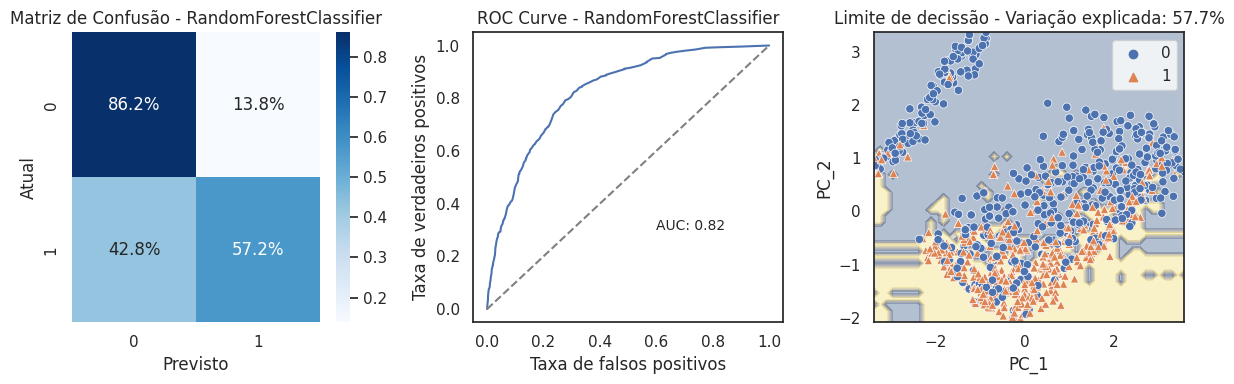

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3880, number of negative: 3880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2673
[LightGBM] [Info] Number of data points in the train set: 7760, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3880, number of negative: 3880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7760, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


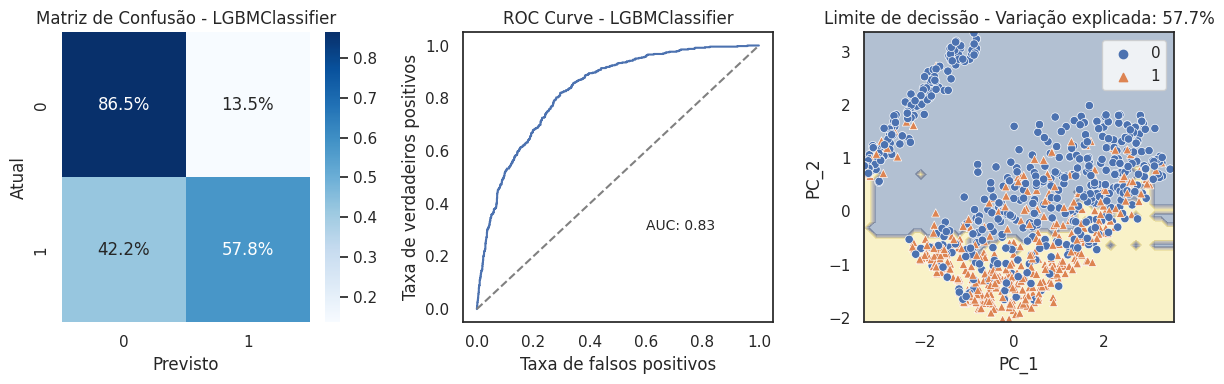

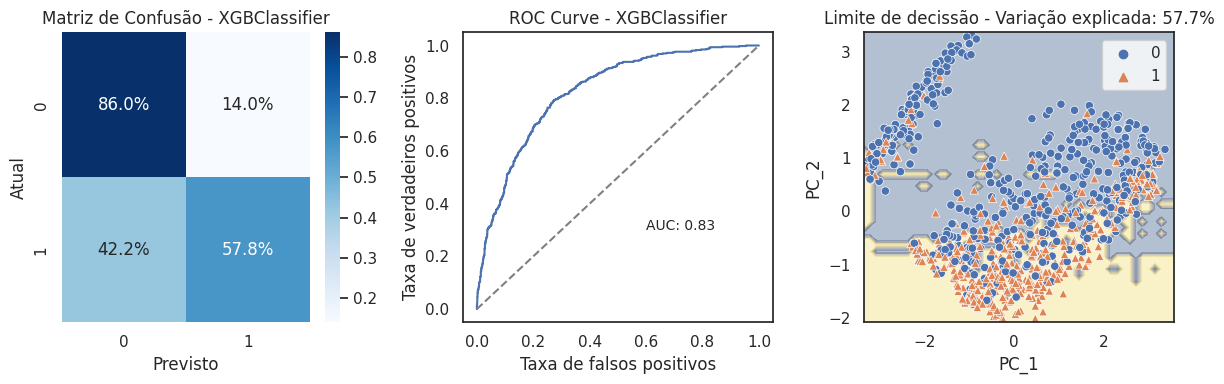

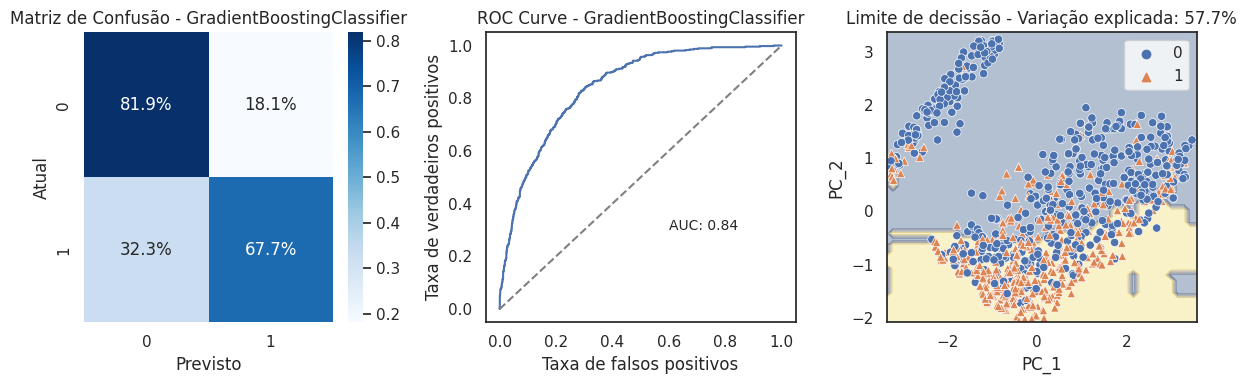

In [62]:
evaluate_models_df(X_train, y_train, X_test, y_test)


Os resultados desses modelos indicam uma tendência comum em termos de desempenho geral, mas com algumas diferenças notáveis nos detalhes das previsões e capacidade de discriminação.

- Desempenho semelhante na matriz de confusão 0-0 e 1-1: Todos os modelos apresentam taxas de acerto elevadas para a classe 0 (86-86.5%), indicando uma boa capacidade de identificar corretamente os verdadeiros negativos. Isso pode sugerir que os modelos estão bem ajustados para reconhecer casos negativos.

- Taxas de acerto para a classe 1 (1-1): Todos os modelos apresentam taxas de acerto para a classe 1 (positivos) em torno de 57-58%, o que é consideravelmente menor do que as taxas para a classe 0. Isso pode indicar uma dificuldade dos modelos em identificar corretamente os verdadeiros positivos.

- AUC (Área sob a curva ROC): Todos os modelos têm valores de AUC em torno de 0.83-0.84. Isso sugere que todos têm uma capacidade semelhante de classificar corretamente exemplos positivos e negativos em diferentes thresholds, com uma boa capacidade de discriminação entre as classes, mas não excelente.

- Gradient Boosting com desempenho distinto na classe 1: O Gradient Boosting apresenta uma taxa de acerto para a classe 1 (positivos) um pouco mais alta (67.7%) em comparação com os outros modelos. Isso pode indicar uma especialização ou ajuste mais eficaz para identificar verdadeiros positivos, embora ainda com espaço para melhorias na taxa de acerto para essa classe.



**Desempenho Geral dos Modelos e Conclusão:**

- Todos os modelos exibem um desempenho notável na identificação dos verdadeiros negativos (classe 0), alcançando taxas de acerto em torno de 86-86.5%. Isso sugere uma boa capacidade dos modelos em reconhecer corretamente exemplos negativos.

- Desafios na Identificação dos Verdadeiros Positivos (classe 1): os modelos apresentam taxas de acerto relativamente menores para a classe positiva (1-1), variando entre 57-58%. Isso indica uma dificuldade em identificar corretamente exemplos positivos, o que pode ser um ponto de melhoria significativo.

- Capacidade de Discriminação: todos os modelos exibem valores de AUC em torno de 0.83-0.84, indicando uma habilidade consistente de distinguir entre as classes, embora não excepcionalmente alta.

- Destaque do Gradient Boosting na Classe 1: o modelo Gradient Boosting se destaca com uma taxa de acerto para a classe 1 um pouco mais alta (67.7%) em comparação com os outros modelos, sugerindo uma especialização ou ajuste mais eficaz para identificar verdadeiros positivos.

- Hipóteses para Melhorias: as diferenças de desempenho podem ser atribuídas ao desbalanceamento de classes, problemas na engenharia de características, configuração de hiperparâmetros ou até mesmo características específicas do problema ou domínio dos dados.

- Necessidade de Investigação Adicional:explorar mais a fundo cada hipótese e conduzir análises adicionais, como otimização de hiperparâmetros, seleção de características mais relevantes e possivelmente experimentação com outras técnicas de modelagem, pode levar a melhorias substanciais no desempenho dos modelos.